In [ ]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import pandas as pd
from numpy import array
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from math import sin, pi
from scipy import signal
import matplotlib.pyplot as plt

from model import *

C:\Users\Артем\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\signal\_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)


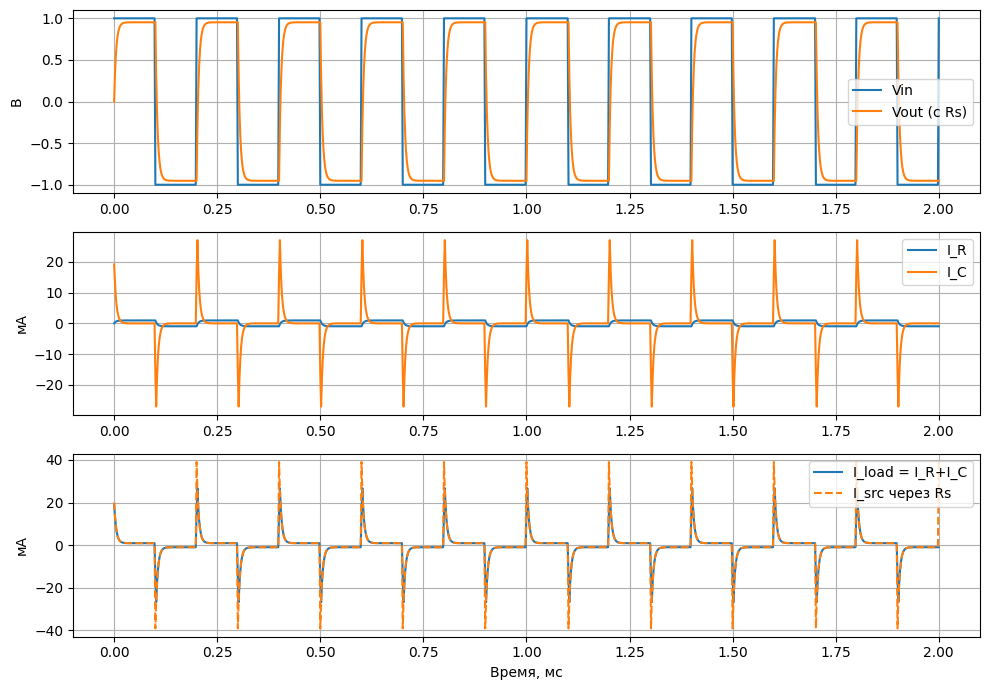

In [ ]:
def rc_current_ideal(v, fs, R, C):
    # v — массив напряжения на нагрузке (меандр), fs — частота дискретизации
    dv_dt = np.gradient(v, 1/fs, edge_order=2)  # производная
    i_R   = v / R
    i_C   = C * dv_dt
    return i_R + i_C, i_R, i_C

# Параметры
fs = 500_000
f0 = 5_000
T  = 2e-3
t  = np.arange(0, T, 1/fs)
Vin_amp = 1.0  # ±1 В
vin = Vin_amp * signal.square(2*np.pi*f0*t)  # -1..+1 В

R  = 1e3
C  = 1e-7
Rs = 50

# Идеальный источник
i_ideal, iR_id, iC_id = rc_current_ideal(vin, fs, R, C)

def rc_current_with_rs(vin, fs, R, C, Rs):
    # 1) дискретизация H(s) (Zero-Order Hold)
    num = [R]
    den = [Rs*R*C, R+Rs]
    bd, ad, dt = signal.cont2discrete((num, den), dt=1/fs, method='zoh')[:3]
    bd = bd.flatten()

    # 2) отклик напряжения на нагрузке
    _, vout = signal.dlsim((bd, ad, dt), vin)
    vout = vout.flatten()

    # 3) токи
    dv_dt = np.gradient(vout, 1/fs, edge_order=2)
    i_R   = vout / R
    i_C   = C * dv_dt
    i_load = i_R + i_C

    # ток источника (через Rs): (vin - vout)/Rs
    i_src = (vin - vout)/Rs if Rs > 0 else i_load
    return i_load, i_R, i_C, vout, i_src

# Источник с Rs
i_load, i_R, i_C, vout, i_src = rc_current_with_rs(vin, fs, R, C, Rs)

plt.figure(figsize=(10,7))
plt.subplot(3,1,1)
plt.plot(t*1e3, vin, label='Vin')
plt.plot(t*1e3, vout, label='Vout (с Rs)')
plt.ylabel('В')
plt.legend(); plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t*1e3, i_R*1e3, label='I_R')
plt.plot(t*1e3, i_C*1e3, label='I_C')
plt.ylabel('мА')
plt.legend(); plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t*1e3, i_load*1e3, label='I_load = I_R+I_C')
plt.plot(t*1e3, i_src*1e3, '--', label='I_src через Rs')
plt.ylabel('мА'); plt.xlabel('Время, мс')
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt

def iq_phase_vs_time(x, fs, f0, bw_frac=0.2, order=4):
    """
    Возвращает моментальную фазу сигнала x(t) вокруг частоты f0.
    Выделяем узкую полосу (f0 ± bw_frac*f0/2), затем Хилберт через I/Q.
    """
    # Узкополосный фильтр вокруг f0 (рекомендуется, т.к. у меандра много гармоник)
    f1 = (f0*(1-bw_frac/2)) / (fs/2)
    f2 = (f0*(1+bw_frac/2)) / (fs/2)
    b, a = butter(order, [f1, f2], btype='band')
    x_f = filtfilt(b, a, x)

    # I/Q демодуляция
    t = np.arange(len(x))/fs
    sin_c = np.sin(2*np.pi*f0*t)
    cos_c = np.cos(2*np.pi*f0*t)
    I = x_f * cos_c
    Q = x_f * sin_c

    # НЧ-фильтр для усреднения I/Q (можно тем же butter, но НЧ)
    fc_lp = f0/8   # частота среза LP (подстрой под динамику фазы)
    blp, alp = butter(3, fc_lp/(fs/2))
    I_lp = filtfilt(blp, alp, I)
    Q_lp = filtfilt(blp, alp, Q)

    phase = np.unwrap(np.arctan2(Q_lp, I_lp))  # рад
    return phase

def phase_diff_vs_time(v, i, fs, f0):
    phi_v = iq_phase_vs_time(v, fs, f0)   # фаза напряжения на f0
    phi_i = iq_phase_vs_time(i, fs, f0)   # фаза тока на f0
    dphi  = np.unwrap(phi_i - phi_v)      # разность фаз (рад)
    return dphi, phi_v, phi_i

In [ ]:
from scipy.signal import csd

def phase_at_f0(v, i, fs, f0, nperseg=None):
    # Кросс-спектр i относительно v (важен порядок!)
    f, S_iv = csd(i, v, fs=fs, nperseg=(nperseg or 4*int(fs/f0)))
    # Берём ближайший бин к f0
    k = np.argmin(np.abs(f - f0))
    phase = np.angle(S_iv[k])          # рад
    phase_deg = np.degrees(phase)      # градусы в диапазоне (-180, 180]
    return phase_deg

-61.89663169248747


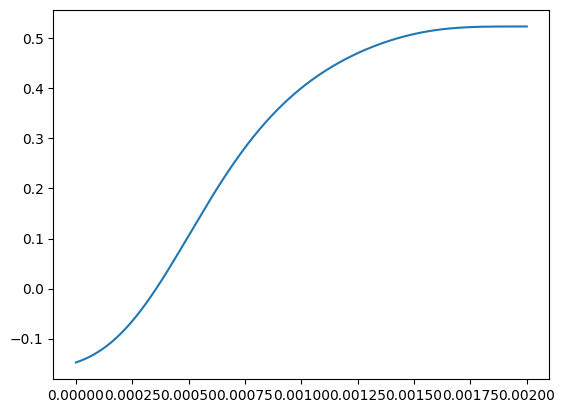

In [ ]:
dphi, phi_v, phi_i=phase_diff_vs_time (vin,i_load,fs,f0)
phase =phase_at_f0(vin,i_load,fs,f0)
print (phase)
plt.plot(t,phi_i)